# Structured data predictor


In this notebook, we will do the following

Use a simple data set (Sloan Digital Sky Survey) https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey and banking data set https://www.kaggle.com/jonathanlicis/bank-marketing-data-set
Create two types of splits. Every split will create three types of data - training data, testing data and productiond data
- Random split
- Biased split

Biased split are used to introduce some drift

- Train a Scikit learn model on the train data. Verify on test data and also look at the performance of the model on the production data
- Fit a structured data predictor using the trained model, train/test data
- Calculate the predictions as returned by the predictor on the production data




In [1]:
import sys
sys.path.append("/Users/anu/Documents/GitHub/UQ360_Oct_Anu")


Download the CSV dataset from https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey and place it in your local disk.  

# Random Split using Sloan Digital

### Data Preparation

In [2]:
import pandas as pd

local_file = "/Users/anupamamurthi/Downloads/sdss.csv"
columns = {"ordered_categorical_columns": [],
        "categorical_columns": [],
        "numerical_columns": ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field', 
                    'specobjid', 'redshift', 'plate', 'mjd', 'fiberid'],
        "text_columns": [],
        "ignore_columns": ['objid', 'rerun'],
        "targets": 'class'}

has_header = True
separator = ","
try:
    if has_header:
        df = pd.read_csv(local_file, sep=separator, na_values=["unknown"], engine='python')
    else:
        df = pd.read_csv(local_file, sep=separator, na_values=["unknown"], engine='python', header=None)
except:
    raise Exception("Cannot read local file: {}".format(local_file))


In [3]:
df.head(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = df.drop(columns.get('ignore_columns', []), axis=1)

df = df.dropna(axis=0, how='any')

# Get target value 'y'
y_label = columns.get("targets", 'y')
y = df[y_label].values
df = df.drop([y_label], axis=1)  # Remove labels from feature set x'


task = "classification"
if task == "classification":
    class_dict = {}
    for ind, label in enumerate(np.unique(y)):
        class_dict[ind] = str(label)
else:
    class_dict = None
# metadata['class_dict'] = class_dict


# Encode labels as int
le = LabelEncoder()
y = le.fit_transform(y)

features = list(df.columns.values)
print('Features after dropping a few: ', features)

Features after dropping a few:  ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid']


Random split with no drift

In [12]:
# Create train test prod data

def create_train_test_prod_split(x, y, test_size=0.25 ):
    """
    returns x_train, y_train, x_test, y_test, x_prod, y_prod
    """
    from sklearn.model_selection import StratifiedKFold, train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                                    test_size=0.25, 
                                                                random_state=42)

    x_test, x_prod, y_test, y_prod = train_test_split(x_test, y_test,
                                                                    test_size=0.25, 
                                                                random_state=42)

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_prod.shape, y_prod.shape)

    
    print("Training data size:", x_train.shape)
    print("Test data size:", x_test.shape)
    print("Prod data size:", x_prod.shape)
    
    return x_train, y_train, x_test, y_test, x_prod, y_prod

In [13]:
# x
# features dictionary will represent the feature vector. "x" will contain one hot encoded data but "features" dict
# will maintain the original structure, making it easy to filter and create biased splits.
# x and features are both the same data but represented differently

from sklearn.preprocessing import OneHotEncoder
metadata = {}
# identify categorical vs numerical columns
categorical_columns = columns.get("categorical_columns", [])
ordered_categorical_columns = columns.get("ordered_categorical_columns", [])
numerical_columns = columns.get("numerical_columns", [])
# use label encoder to convert string into numerical values
ohe = OneHotEncoder(categories='auto', sparse=False)
if categorical_columns or ordered_categorical_columns:  # if there are categorical variables, store details
    metadata['categorical_column_details'] = {}
features = {}

# feature_names = {}
for column in df.columns.values:
    if column in ordered_categorical_columns:
        features[str(column)] = le.fit_transform(df[column].values.astype('str')).reshape(-1, 1)
        metadata['categorical_column_details'][column] = list(le.classes_)
    elif column in categorical_columns:
        features[str(column)] = ohe.fit_transform(df[column].values.astype('str').reshape(-1, 1))
    else:  # By default if not labeled as categorical, treat as numeric
        features[str(column)] = df[column].values.astype('float').reshape(-1, 1)

x = np.concatenate([np.array(v, dtype=float) for k, v in features.items()], axis=1)

In [14]:
x_train, y_train, x_test, y_test, x_prod, y_prod = create_train_test_prod_split(x, y)


(28683, 34) (28683,) (7171, 34) (7171,) (2391, 34) (2391,)
Training data size: (28683, 34)
Test data size: (7171, 34)
Prod data size: (2391, 34)
(28683, 34) (28683,) (7171, 34) (7171,) (2391, 34) (2391,)
Training data size: (28683, 34)
Test data size: (7171, 34)
Prod data size: (2391, 34)


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [16]:
# rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)


RandomForestClassifier()

RandomForestClassifier()

In [17]:

acc_on_test = rf.score(x_test, y_test)
print('Accuracy on test: ',acc_on_test*100)

Accuracy on test:  91.2703946450983
Accuracy on test:  91.2703946450983


In [18]:

acc_on_prod = rf.score(x_prod, y_prod)
print('Accuracy on prod: ',acc_on_prod*100)

Accuracy on prod:  91.13341698034296
Accuracy on prod:  91.13341698034296


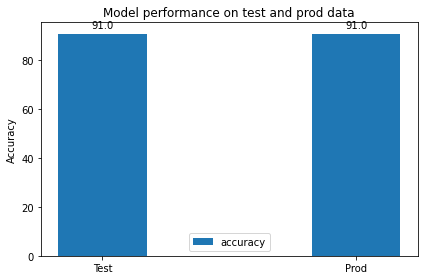

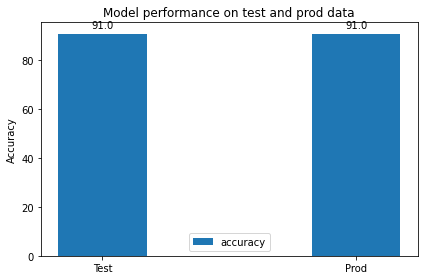

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Test', 'Prod']
men_means = [round(acc_on_test,2)*100, round(acc_on_prod,2)*100]
err = [0,0]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x , men_means, width, label='accuracy', yerr=err)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model performance on test and prod data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend() 

def label(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


label(rects1)

fig.tight_layout()

plt.show()

In [20]:
import sys
sys.path.append("/Users/anupamamurthi/Documents/GitHub/UQ360/")

# It is possible to train the predictor using encoded data or using raw text. 

# In the below example, we are using raw text to train the predictor but x_train can be swapped with x_train_encoded

from uq360.algorithms.blackbox_metamodel.structured_data_classification import StructuredDataClassificationWrapper
import numpy as np
import pickle

p = StructuredDataClassificationWrapper(base_model=rf)

p.fit(x_train, y_train, x_test, y_test)

Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy', 'gbm', 'class_frequency', 'random_forest', 'logistic_regression', 'one_class_svm', 'umap_kde']
Blackbox features : ['pp_std', 'pp_entropy', 'pp_bootstrap', 'base_model_entropy_ratio', 'predicted_accuracy_change', 'pp_uncertainty']
Predictor type : structured_data
Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy'

In [21]:
prediction, y_pred, y_score = p.predict(x_prod)  

Features extracted for : odict_keys(['confidence_top', 'confidence_delta', 'confidence_entropy', 'gbm_1', 'gbm_2', 'class_frequency', 'random_forest_1', 'random_forest_2', 'logistic_regression_1', 'logistic_regression_2', 'one_class_svm', 'umap_kde'])
Features extracted for : odict_keys(['confidence_top', 'confidence_delta', 'confidence_entropy', 'gbm_1', 'gbm_2', 'class_frequency', 'random_forest_1', 'random_forest_2', 'logistic_regression_1', 'logistic_regression_2', 'one_class_svm', 'umap_kde'])


In [22]:
prediction

90.96942667810414

90.96942667810414

In the above use case, the model appears to perform well on both production and test data. Performance predictor predicts the same.

# Use case 2: Biased split (Banking dataset)


Refer to uq360/data/banking_data/README.md for instructions on downloading banking dataset

In [23]:
import pandas as pd
local_file = "/Users/anu/Documents/GitHub/UQ360_Oct_Anu/uq360/data/banking_data/bank-additional/bank-additional-full.csv"

file = {"filename":"bank-additional-full.csv", "separator":";", "extension":".csv"}
columns = {
    "ordered_categorical_columns": ["education"],
        "categorical_columns": ["job", "marital", "housing", "loan", "contact", "poutcome"],
        "numerical_columns": ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        "text_columns": [],
        "ignore_columns": ["default","month","day_of_week"],
        "targets": "y"}
separator = file.get('separator', ',')

has_header = True
try:
    if has_header:
        df = pd.read_csv(local_file, sep=separator, na_values=["unknown"], engine='python' )
    else:
        df = pd.read_csv(local_file, sep=separator, na_values=["unknown"], engine='python', header=None, compression="gzip")
except:
    raise Exception("Cannot read local file: {}".format(local_file))


In [24]:
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [25]:
# Data clean up
import numpy as np
df = df.drop(columns.get('ignore_columns', []), axis=1)

df = df.dropna(axis=0, how='any')

# Get target value 'y'
y_label = columns.get("targets", 'y')
y = df[y_label].values
df = df.drop([y_label], axis=1)  # Remove labels from feature set x'

task = "classification"
if task == "classification":
    class_dict = {}
    for ind, label in enumerate(np.unique(y)):
        class_dict[ind] = str(label)
else:
    class_dict = None

In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as int
le = LabelEncoder()
y = le.fit_transform(y)

features = list(df.columns.values)
print('Features after dropping a few: ', features)

Features after dropping a few:  ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Features after dropping a few:  ['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [27]:
# features dictionary will represent the feature vector. "x" will contain one hot encoded data but "features" dict
# will maintain the original structure, making it easy to filter and create biased splits.
# x and features are both the same data but represented differently

from sklearn.preprocessing import OneHotEncoder
metadata = {}
# identify categorical vs numerical columns
categorical_columns = columns.get("categorical_columns", [])
ordered_categorical_columns = columns.get("ordered_categorical_columns", [])
numerical_columns = columns.get("numerical_columns", [])
# use label encoder to convert string into numerical values
ohe = OneHotEncoder(categories='auto', sparse=False)
if categorical_columns or ordered_categorical_columns:  # if there are categorical variables, store details
    metadata['categorical_column_details'] = {}
features = {}

# feature_names = {}
for column in df.columns.values:
    if column in ordered_categorical_columns:
        features[str(column)] = le.fit_transform(df[column].values.astype('str')).reshape(-1, 1)
        metadata['categorical_column_details'][column] = list(le.classes_)
    elif column in categorical_columns:
        features[str(column)] = ohe.fit_transform(df[column].values.astype('str').reshape(-1, 1))
    else:  # By default if not labeled as categorical, treat as numeric
        features[str(column)] = df[column].values.astype('float').reshape(-1, 1)


In [28]:
# x
x = np.concatenate([np.array(v, dtype=float) for k, v in features.items()], axis=1)

In [29]:
print(x.shape, y.shape)

(38245, 34) (38245,)
(38245, 34) (38245,)


In [30]:
from sklearn.ensemble import RandomForestClassifier

# create a random train/test/prod split
x_train, y_train, x_test, y_test, x_prod, y_prod = create_train_test_prod_split(x, y)

rf = RandomForestClassifier()
from sklearn.ensemble import RandomForestClassifier
rf.fit(x_train, y_train)

acc_on_test = rf.score(x_test, y_test)
print('Accuracy on test: ',acc_on_test*100)
acc_on_prod = rf.score(x_prod, y_prod)
print('Accuracy on prod: ',acc_on_prod*100)

(28683, 34) (28683,) (7171, 34) (7171,) (2391, 34) (2391,)
Training data size: (28683, 34)
Test data size: (7171, 34)
Prod data size: (2391, 34)
(28683, 34) (28683,) (7171, 34) (7171,) (2391, 34) (2391,)
Training data size: (28683, 34)
Test data size: (7171, 34)
Prod data size: (2391, 34)
Accuracy on test:  91.28433970157579
Accuracy on prod:  91.38435800920118
Accuracy on test:  91.28433970157579
Accuracy on prod:  91.38435800920118


In [31]:
from uq360.algorithms.blackbox_metamodel.structured_data_classification import StructuredDataClassificationWrapper
import numpy as np
import pickle

p1 = StructuredDataClassificationWrapper(base_model=rf)
p1.fit(x_train, y_train, x_test, y_test)
prediction, y_pred, y_score  = p1.predict(x_prod)  

# There is no drift and the predictor's prediction matches
print(prediction)

Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy', 'gbm', 'class_frequency', 'random_forest', 'logistic_regression', 'one_class_svm', 'umap_kde']
Blackbox features : ['pp_std', 'pp_entropy', 'pp_bootstrap', 'base_model_entropy_ratio', 'predicted_accuracy_change', 'pp_uncertainty']
Predictor type : structured_data
Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy'

The next few lines represent a recipe to generate a biased split. In the below example, we consider the feature "nr.employed" and consider two buckets

- number of employees <= 5150 (bucket 0)
- number of employees > 5150 (bucket 1)

Three types of data will be generated 

- Training data (65%)
- Test data (20%)
- Production data (pool/log data) (10%)

When generating training and test data, we grab 10% of the data from bucket 0 and 90% of the data from bucket 1. This would mean, the model will learn more about bucket 1.
In like manner, when generating "production data", we grab 90% of the data from bucket 0 and 10% of the data from bucket 1.


In [32]:
metadata =  {"buckets": [{"key": "nr.employed", "type": "feature", "condition": "lambda x, y: x if y <= 5150  else None", "name": "bucket_0_less_than_5090"},
                         {"key": "nr.employed", "type": "feature", "condition": "lambda x, y: x if y > 5150 else None", "name": "bucket_1_more_than_5090"}], 
             "bucketizer": {"name": "nr_employees_based_split_predict_y", 
                            "x": "x", 
                            "train_test_prod": [0.65, 0.25, 0.1], 
                            "bias_buckets": ["bucket_0_less_than_5090", "bucket_1_more_than_5090"], 
                            "y": "y", 
                            "batches": [{"name": "batch_4", "bias_size": [[0.1, 0.9], [0.1, 0.9], [0.9, 0.1]]}]
                           }
            }



In [33]:
import logging

name = "biased_split"
logger = logging.getLogger(name)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    filename=None)
logger.setLevel(logging.INFO)

split_config = metadata
splits = []
tmp_locations = []
split=split_config

if 'bias_buckets' not in split['bucketizer']:
    raise Exception('bias_buckets is not specified! Bailing out')

if 'batches' not in split['bucketizer']:
    raise Exception('batches is not specified. There should atleast be one batch! bailing out..')

batches = split['bucketizer']['batches']

out_data = x
out_labels = y
biased_splits = []
bias_buckets = split['bucketizer']['bias_buckets']
bias_splits = {}




In [34]:
# move data into buckets
import math
if len(y) == 0 :
    out_labels = features[split['bucketizer']['y']]

logging.info(' $$$$$$$$$$$ handling biased buckets $$$$$$$$$$ ')
bucket_detail = None
for bias_bucket in bias_buckets:
    logging.info('handling bias bucket %s', bias_bucket)
    for bkt in split['buckets']:
        if bkt['name'] == bias_bucket:
            bucket_detail = bkt
            break
    # grab from features only if key is not y (which is the default)
    out_labels_final = []
    if 'key' in bucket_detail and bucket_detail['key'] != 'y':
        out_labels_final = features.get(bucket_detail['key'], [])

    condition = eval(bucket_detail['condition'])

    if len(out_labels_final) != 0:
        try:
            output = list(map(condition, out_data, out_labels_final))
        except ValueError as e:
            # not the best approach! handling a scenario when the feature we split on is one-hot-encoded
            print(e)
            if str(e).startswith('The truth value of an array with more than one element is ambiguous'):
                out_labels_final = [np.argmax(i) for i in out_labels_final]
                output = list(map(condition, out_data, out_labels_final))
    else:
        output = list(map(condition, out_data, out_labels))
    out1 = []
    out2 = []
    for index, item in enumerate(output):
        if item is not None:
            out1.append(item)
            out2.append(out_labels[index])

    out1 = np.array(out1)
    out2 = np.array(out2)
    bias_splits[bias_bucket] = {"x": out1, "y": out2, "len": len(out1)}


train_dist = split['bucketizer']['train_test_prod'][0]
test_dist = split['bucketizer']['train_test_prod'][1]
prod_dist = split['bucketizer']['train_test_prod'][2]



2021-10-19 00:07:21,009 - root - INFO -  $$$$$$$$$$$ handling biased buckets $$$$$$$$$$ 
2021-10-19 00:07:21,009 - root - INFO -  $$$$$$$$$$$ handling biased buckets $$$$$$$$$$ 
2021-10-19 00:07:21,011 - root - INFO - handling bias bucket bucket_0_less_than_5090
2021-10-19 00:07:21,011 - root - INFO - handling bias bucket bucket_0_less_than_5090
2021-10-19 00:07:21,075 - root - INFO - handling bias bucket bucket_1_more_than_5090
2021-10-19 00:07:21,075 - root - INFO - handling bias bucket bucket_1_more_than_5090


In [35]:
# Create a biased split by distributing the data from the two buckets into train, test, prod

from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier

# start with min batch size
batch_size = 100
master_name = name

for batch in batches:
    logging.info(' ************************* Handling batch %s ************************* ', batch)
    name = master_name # Reset name for each batch
    try:
        magic_number = None
        
        train = batch['bias_size'][0]
        test = batch['bias_size'][1]
        prod = batch['bias_size'][2]

        dist = [0] * len(bias_buckets)  # size of buckets

        # iterate thro all elements in train
        train_dist_per_bucket = [0] * len(bias_buckets)
        test_dist_per_bucket = [0] * len(bias_buckets)
        prod_dist_per_bucket = [0] * len(bias_buckets)

        for index, item in enumerate(train):
            dist[index] = dist[index] + round(train_dist * item, 2)
            train_dist_per_bucket[index] = round(train_dist * item, 2) * batch_size

        for index, item in enumerate(test):
            dist[index] = dist[index] + round(test_dist * item, 2)
            test_dist_per_bucket[index] = round(test_dist * item, 2) * batch_size

        for index, item in enumerate(prod):
            dist[index] = dist[index] + round(prod_dist * item, 2)
            prod_dist_per_bucket[index] = round(prod_dist * item, 2) * batch_size

        logging.info(' ###### per bucket distribution ##### ')

        logging.info('train %s' , train_dist_per_bucket)
        logging.info('test %s' , test_dist_per_bucket)
        logging.info('prod %s' , prod_dist_per_bucket)

        # at this point dist will have len = number of buckets

        dist = [i * batch_size for i in dist]

        number_of_iterations = [0] * len(bias_buckets)
        for index, bkt in enumerate(bias_buckets):
            bkt_len = bias_splits[bkt]['len']
            number_of_iterations[index] = math.floor(bkt_len / dist[index])

        # magic number really determines the number of times you want to go around distributing the data
        logging.info('magic number %s', min(number_of_iterations))
        magic_number = min(number_of_iterations)

        # train_dist_per_bucket
        train_dist_per_bucket = [i * magic_number for i in train_dist_per_bucket]
        test_dist_per_bucket = [i * magic_number for i in test_dist_per_bucket]
        prod_dist_per_bucket = [i * magic_number for i in prod_dist_per_bucket]

        logging.info("%s %s %s",train_dist_per_bucket, test_dist_per_bucket, prod_dist_per_bucket)

        # note, train_dist_per_bucket is of len = buckets
        loop_index = 0

        # we will loop thro each bucket now
        x_train_final = []
        y_train_final = []

        x_test_final = []
        y_test_final = []

        x_prod_final = []
        y_prod_final = []
    
        while True:
            if loop_index >= len(bias_buckets):
                break

            bucket_name = bias_buckets[loop_index]

            logging.info('handling bucket...%s', loop_index)
            logging.info('%s %s %s',train_dist_per_bucket[loop_index], test_dist_per_bucket[loop_index], prod_dist_per_bucket[loop_index])

            train_size = round(train_dist_per_bucket[loop_index] + test_dist_per_bucket[loop_index])
            prod_size = round(prod_dist_per_bucket[loop_index])

            logging.info('create train_test and prod')
            logging.info('train_size %s test_size %s', train_size, prod_size)
            if train_size == 0 and prod_size > 0:
                x_train_test = np.array([])
                y_train_test = np.array([])
                x_prod = bias_splits[bucket_name]["x"]
                y_prod = bias_splits[bucket_name]["y"]
            elif prod_size == 0 and train_size > 0:
                x_train_test = bias_splits[bucket_name]["x"]
                y_train_test = bias_splits[bucket_name]["y"]
                x_prod = np.array([])
                y_prod = np.array([])
            else:
                x_train_test, x_prod, y_train_test, y_prod = train_test_split(bias_splits[bucket_name]["x"],
                                                                            bias_splits[bucket_name]["y"],
                                                                            train_size=train_size,
                                                                            test_size=prod_size)

            # edges 0,1 / 1,0 split
            if len(x_train_test) != 0 and len(x_prod)!=0:
                train_size = math.floor(train_dist_per_bucket[loop_index])
                test_size = math.floor(test_dist_per_bucket[loop_index])
                if train_size == 0 and test_size > 0:
                    x_train = np.array([])
                    y_train = np.array([])
                    x_test = x_train_test
                    y_test = y_train_test
                elif train_size > 0 and test_size == 0:
                    x_train = x_train_test
                    y_train = y_train_test
                    x_test = np.array([])
                    y_test = np.array([])
                else:
                    x_train, x_test, y_train, y_test = train_test_split(x_train_test, y_train_test,
                                                                            train_size = train_size,
                                                                            test_size=test_size)
                x_train_final.extend(x_train)
                y_train_final.extend(y_train)

                x_test_final.extend(x_test)
                y_test_final.extend(y_test)

                x_prod_final.extend(x_prod)
                y_prod_final.extend(y_prod)

            else:
                if len(x_train_test) == 0:
                    x_prod_new, x_throw, y_prod_new, y_throw = train_test_split(x_prod, y_prod,
                                                                        train_size=math.floor(
                                                                            prod_dist_per_bucket[loop_index]))
                    x_prod_final.extend(x_prod_new)
                    y_prod_final.extend(y_prod_new)
                if len(x_prod) == 0:
                    x_train, x_test, y_train, y_test = train_test_split(x_train_test, y_train_test,
                                                                                train_size = math.floor(train_dist_per_bucket[loop_index]),
                                                                                test_size=math.floor(test_dist_per_bucket[loop_index]))
                    x_train_final.extend(x_train)
                    y_train_final.extend(y_train)

                    x_test_final.extend(x_test)
                    y_test_final.extend(y_test)             
            loop_index = loop_index + 1
        
        print(np.asarray(x_train_final).shape,np.asarray(y_train_final).shape,
              np.asarray(x_test_final).shape,np.asarray(y_test_final).shape,
              np.asarray(x_prod_final).shape,np.asarray(y_prod_final).shape)



    except Exception as e:
        raise Exception(e)

2021-10-19 00:07:21,169 - root - INFO -  ************************* Handling batch {'name': 'batch_4', 'bias_size': [[0.1, 0.9], [0.1, 0.9], [0.9, 0.1]]} ************************* 
2021-10-19 00:07:21,170 - root - INFO -  ###### per bucket distribution ##### 
2021-10-19 00:07:21,169 - root - INFO -  ************************* Handling batch {'name': 'batch_4', 'bias_size': [[0.1, 0.9], [0.1, 0.9], [0.9, 0.1]]} ************************* 
2021-10-19 00:07:21,170 - root - INFO - train [7.000000000000001, 59.0]
2021-10-19 00:07:21,170 - root - INFO -  ###### per bucket distribution ##### 
2021-10-19 00:07:21,171 - root - INFO - test [3.0, 23.0]
2021-10-19 00:07:21,170 - root - INFO - train [7.000000000000001, 59.0]
2021-10-19 00:07:21,171 - root - INFO - prod [9.0, 1.0]
2021-10-19 00:07:21,171 - root - INFO - test [3.0, 23.0]
2021-10-19 00:07:21,172 - root - INFO - magic number 310
2021-10-19 00:07:21,171 - root - INFO - prod [9.0, 1.0]
2021-10-19 00:07:21,172 - root - INFO - [2170.000000000

(20460, 34) (20460,) (8060, 34) (8060,) (3100, 34) (3100,)
(20460, 34) (20460,) (8060, 34) (8060,) (3100, 34) (3100,)


In [36]:
# Train a simple RF model and check the accuracy of the model on train 
from uq360.algorithms.blackbox_metamodel.structured_data_classification import StructuredDataClassificationWrapper
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle

rf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=8, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, 
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=576,
               n_jobs=None, oob_score=False, random_state=42, verbose=0,
               warm_start=False)

rf1.fit(x_train_final, y_train_final)

acc_on_test = rf1.score(x_test_final, y_test_final)
print('RF Accuracy on test: ',acc_on_test*100)

acc_on_prod = rf1.score(x_prod_final, y_prod_final)
print('RF Accuracy on prod: ',acc_on_prod*100)


RF Accuracy on test:  93.52357320099256
RF Accuracy on prod:  82.74193548387096
RF Accuracy on test:  93.52357320099256
RF Accuracy on prod:  82.74193548387096


The model appears to be doing pretty well on test set but not so much on the production data. Fit the predictor on train/test data and perform a predict operation to learn about the model's performance on prod data.

In [37]:

from uq360.algorithms.blackbox_metamodel.structured_data_classification import StructuredDataClassificationWrapper
import numpy as np
import pickle

p1 = StructuredDataClassificationWrapper(base_model=rf1)

p1.fit(np.asarray(x_train_final), np.asarray(y_train_final), np.asarray(x_test_final), np.asarray(y_test_final))


prediction, y_pred, y_score  = p1.predict(np.asarray(x_prod_final))  

print("Prediction", prediction)

Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy', 'gbm', 'class_frequency', 'random_forest', 'logistic_regression', 'one_class_svm', 'umap_kde']
Blackbox features : ['pp_std', 'pp_entropy', 'pp_bootstrap', 'base_model_entropy_ratio', 'predicted_accuracy_change', 'pp_uncertainty']
Predictor type : structured_data
Batch features : ['confidence_top_distance', 'confidence_delta_distance', 'confidence_entropy_distance', 'random_forest_distance', 'gbm_distance', 'logistic_regression_distance', 'pca_distance', 'best_feature_distance', 'class_frequency_distance', 'num_important_features', 'bootstrap']
Pointwise features : ['confidence_top', 'confidence_delta', 'confidence_entropy'

As seen about, the predictor predicts the model's accuracy to be around 80% in an extreme drift scenario